#Importing Essetial Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

#Mounting Google Drive To Import The Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Importing Dataset

In [5]:
# Define paths
train_dir = "/content/drive/MyDrive/melanoma/train"
test_dir  = "/content/drive/MyDrive/melanoma/test"

# Define batch size and image size
batch_size = 32
img_size = (224, 224)

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Found 960 files belonging to 2 classes.
Found 240 files belonging to 2 classes.
Class Names: ['benign', 'malignant']


#Visualisation of Train and Test Images

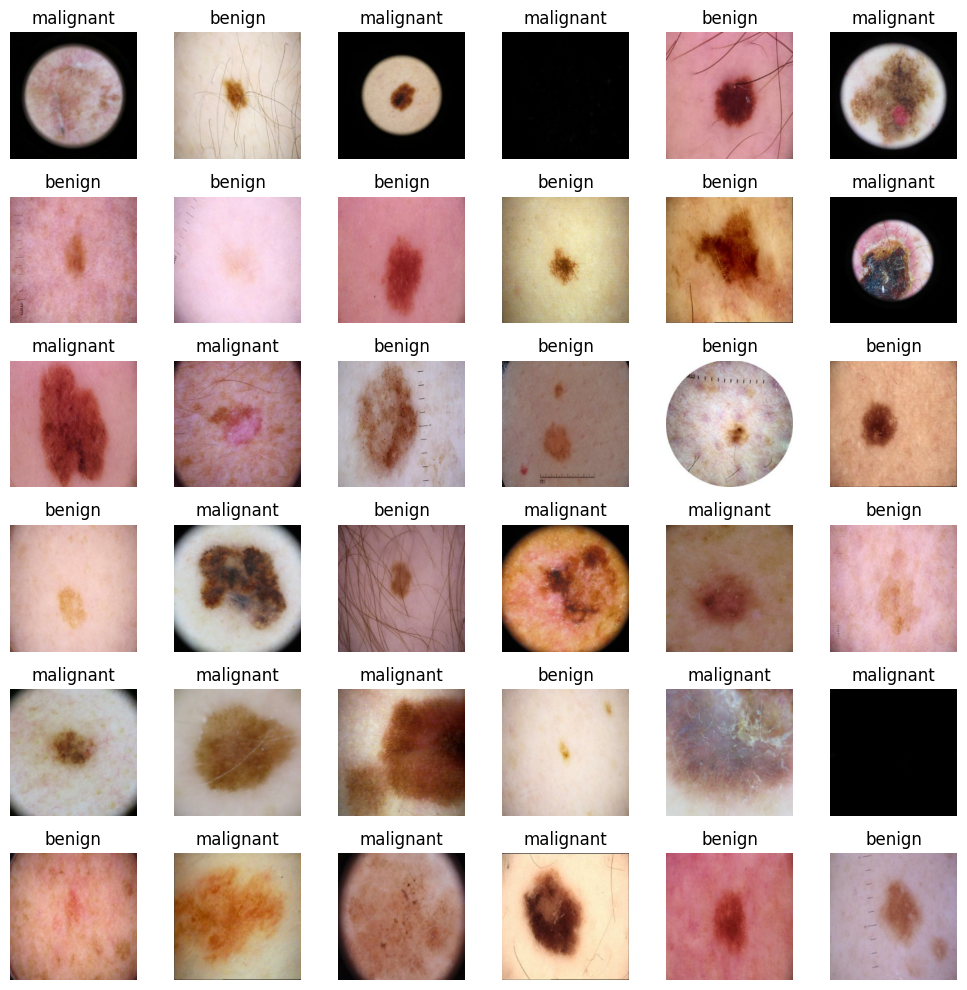

In [6]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# 6x6 grid of random images from train_ds (label_mode='categorical')
plt.figure(figsize=(10,10))
for n, (img, label) in enumerate(train_ds.unbatch().shuffle(2000).take(36)):
    plt.subplot(6, 6, n + 1)
    plt.imshow(tf.cast(img, tf.uint8).numpy())  # images are already RGB
    plt.axis('off')
    plt.title(class_names[int(tf.argmax(label))])
plt.tight_layout()
plt.show()


#EDA

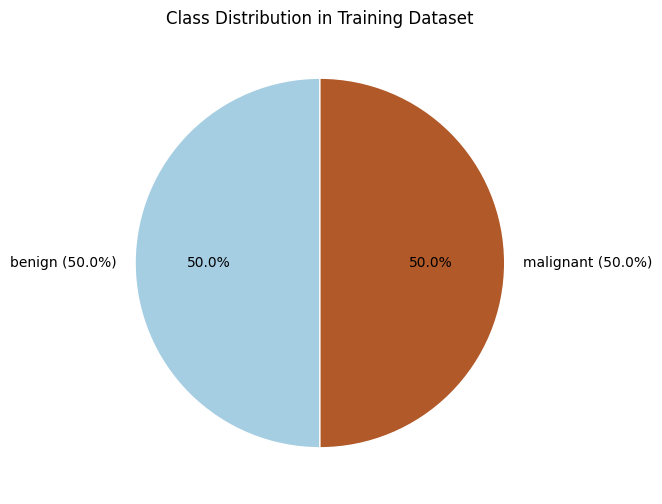

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Count the samples per class from train_ds
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in train_ds:
    class_counts += labels.numpy().sum(axis=0).astype(int)

# Calculate percentages
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot pie chart
plt.figure(figsize=(6, 6))
colors = plt.cm.Paired(np.linspace(0, 1, num_classes))
plt.pie(
    class_counts,
    labels=[f"{cls} ({pct:.1f}%)" for cls, pct in zip(class_names, class_percentages)],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Class Distribution in Training Dataset")
plt.show()


#Data Augmentation And Fine Tuning

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation for training set
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Apply augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

# Prefetch for better performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#Displaying images of each Class after Data Augmentation

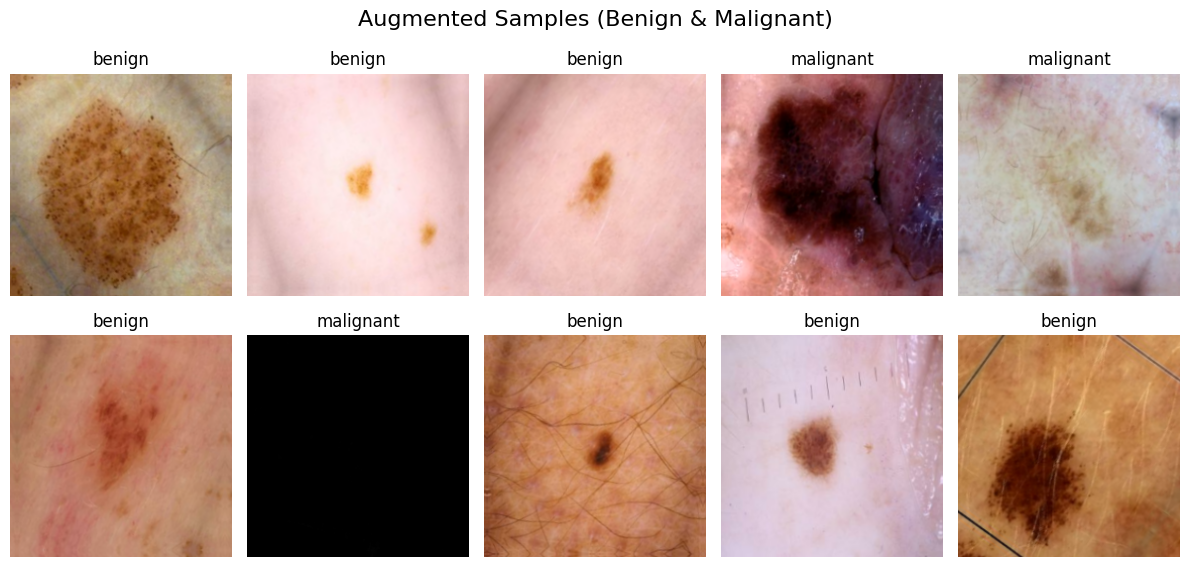

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Get one batch of images and labels
for images, labels in train_ds.take(1):
    images = images[:10]   # take first 10 images for preview
    labels = labels[:10]
    break

# Convert one-hot labels to class indices
label_indices = tf.argmax(labels, axis=1).numpy()

# Plot augmented images
plt.figure(figsize=(12, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.suptitle("Augmented Samples (Benign & Malignant)", fontsize=16)
plt.tight_layout()
plt.show()


#Computing class weights to solve imbalanced dataset

In [10]:
train_labels = np.concatenate([np.argmax(y, axis=1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# Function to plot training history

In [11]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to evaluate model
def evaluate_model(model, dataset, model_name):
    y_true = np.concatenate([np.argmax(y, axis=1) for x, y in dataset])
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"=== Classification Report: {model_name} ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

#Custom CNN


In [12]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [13]:
def build_transfer_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
# Training settings
input_shape = (224,224,3)
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

results = {}

# CNN

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.7514 - loss: 8.8566 - val_accuracy: 0.5917 - val_loss: 57.7209
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.8007 - loss: 5.1538 - val_accuracy: 0.6625 - val_loss: 13.2060
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.8259 - loss: 1.3148 - val_accuracy: 0.6750 - val_loss: 15.5356
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.8353 - loss: 0.9773 - val_accuracy: 0.8208 - val_loss: 2.1804
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8563 - loss: 0.4885 - val_accuracy: 0.7875 - val_loss: 1.2793
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - accuracy: 0.8426 - loss: 0.8587 - val_accuracy: 0.8125 - val_loss: 6.8561
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.8256 - loss: 0.4126 - val_accuracy: 0.8042 - val_loss: 3.3870
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 370ms/step - accuracy: 0.8404 - loss: 0.4354 - val_acc

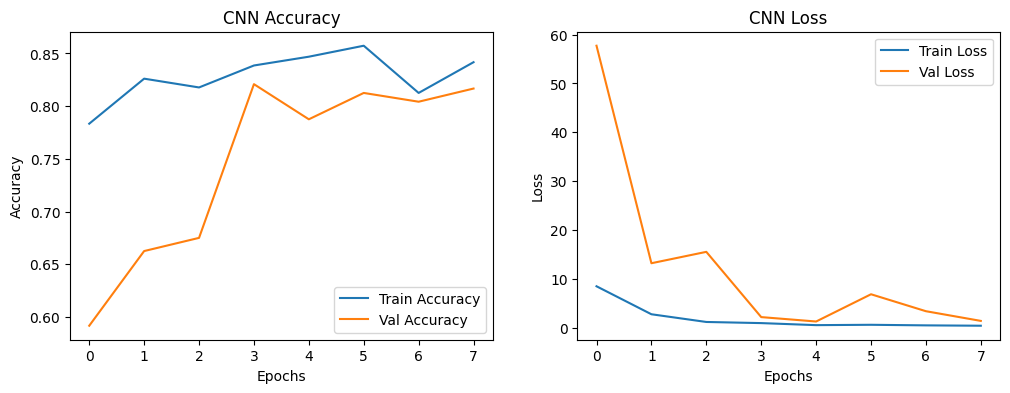

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
=== Classification Report: CNN ===
              precision    recall  f1-score   support

      benign       0.79      0.78      0.79       120
   malignant       0.79      0.79      0.79       120

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240



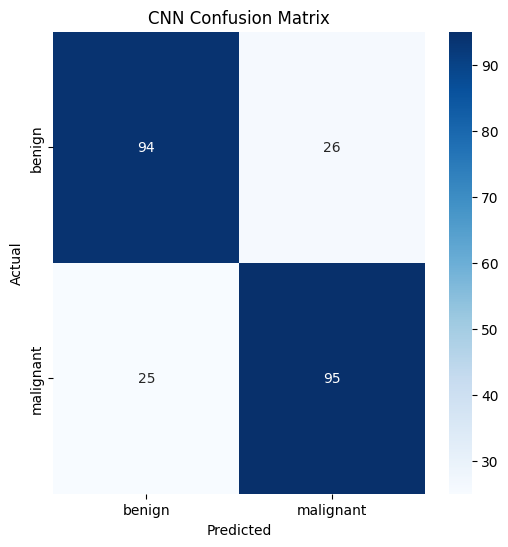

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,737,352 (254.58 MB)

 Trainable params: 22,245,634 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 44,491,270 (169.72 MB)

In [15]:
# Build CNN
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN with EarlyStopping and Class Weights
history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Plot training history
plot_history(history, "CNN")

# Evaluate CNN
evaluate_model(cnn_model, test_ds, "CNN")

# Save history
results["CNN"] = history.history

cnn_model.summary()

#VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 633ms/step - accuracy: 0.6868 - loss: 1.4017 - val_accuracy: 0.8208 - val_loss: 0.6866
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 443ms/step - accuracy: 0.8461 - loss: 0.5116 - val_accuracy: 0.8333 - val_loss: 0.5159
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.8816 - loss: 0.4770 - val_accuracy: 0.8375 - val_loss: 0.5101
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - accuracy: 0.9034 - loss: 0.2508 - val_accuracy: 0.8500 - val_loss: 0.4253
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.9038 - loss: 0.2785 - val_accuracy: 0.8333 - val_loss: 0.5168
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.9078 - loss: 0.2342 - val_accuracy: 0.8083 - val_loss: 0.5748
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 434ms/step - accuracy: 0.9068 - loss: 0.2474 - val_accuracy: 0.8167 - val_loss: 0.6386


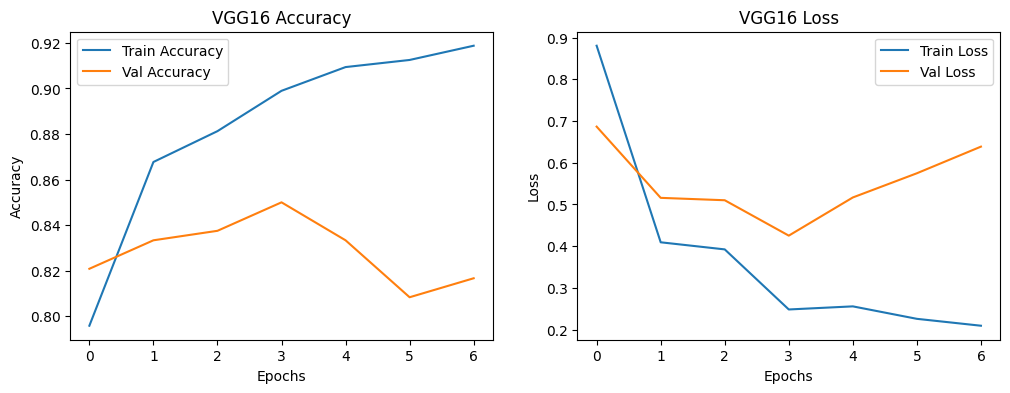

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step
=== Classification Report: VGG16 ===
              precision    recall  f1-score   support

      benign       0.83      0.88      0.85       120
   malignant       0.88      0.82      0.84       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240



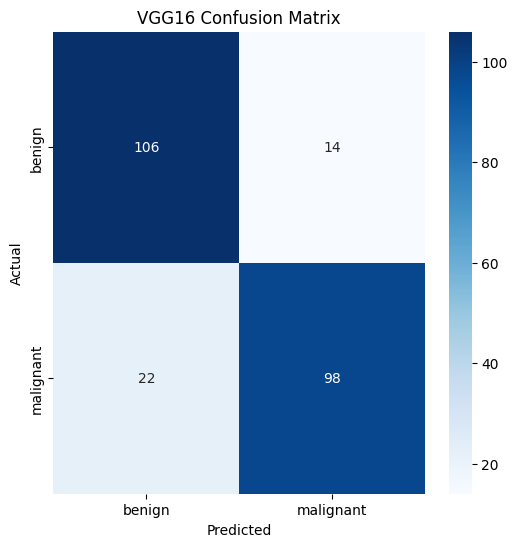

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Load VGG16 without top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_base.trainable = False  # Freeze base layers

# Build transfer learning model
vgg_model = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = vgg_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Plot training history
plot_history(history, "VGG16")

# Evaluate model
evaluate_model(vgg_model, test_ds, "VGG16")

# Save history
results["VGG16"] = history.history

#MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 837ms/step - accuracy: 0.6936 - loss: 0.7235 - val_accuracy: 0.8000 - val_loss: 0.4011
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.7780 - loss: 0.4478 - val_accuracy: 0.7958 - val_loss: 0.3894
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.8093 - loss: 0.4061 - val_accuracy: 0.8042 - val_loss: 0.3918
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 392ms/step - accuracy: 0.8364 - loss: 0.3574 - val_accuracy: 0.8000 - val_loss: 0.3735
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.8460 - loss: 0.3472 - val_accuracy: 0.8292 - val_loss: 0.3637
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.8387 - loss: 0.3757 - val_accuracy: 0.8083 - val_loss: 0.3556
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.8371 - loss: 0.3677 - val_accuracy: 0.8250 - val_loss: 0.3524
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/

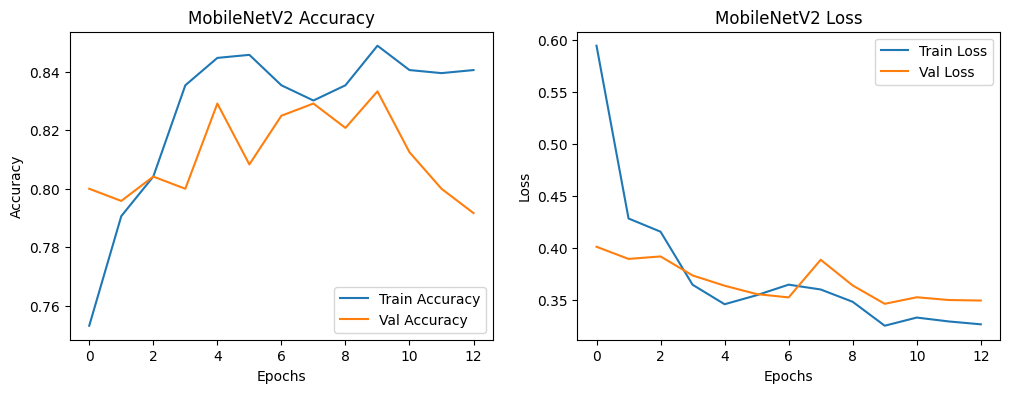

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 582ms/step
=== Classification Report: MobileNetV2 ===
              precision    recall  f1-score   support

      benign       0.79      0.91      0.84       120
   malignant       0.89      0.76      0.82       120

    accuracy                           0.83       240
   macro avg       0.84      0.83      0.83       240
weighted avg       0.84      0.83      0.83       240



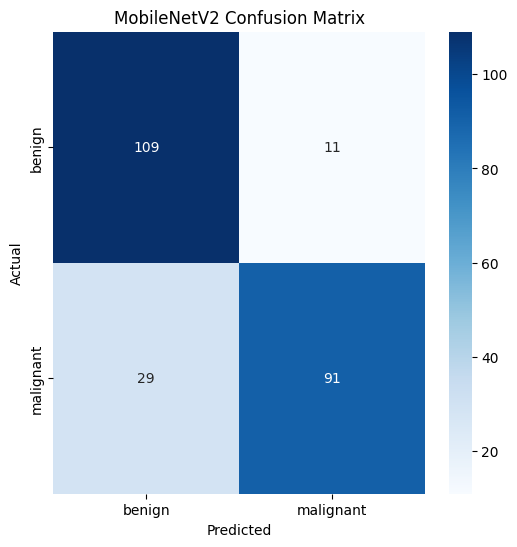

In [17]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 without top layers
mobile_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobile_base.trainable = False  # Freeze base layers

# Build transfer learning model
mobile_model = models.Sequential([
    mobile_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
mobile_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model with EarlyStopping and class weights
history = mobile_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Plot training history
plot_history(history, "MobileNetV2")

# Evaluate model
evaluate_model(mobile_model, test_ds, "MobileNetV2")

# Save history
results["MobileNetV2"] = history.history

In [18]:
from keras.callbacks import ReduceLROnPlateau
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
mobile_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [19]:
# Fit the model
epochs = 30
batch_size=32
history = mobile_model.fit(train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.8566 - loss: 0.3134 - val_accuracy: 0.8292 - val_loss: 0.3443
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.8706 - loss: 0.2956 - val_accuracy: 0.8250 - val_loss: 0.3424
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.8552 - loss: 0.3115 - val_accuracy: 0.7958 - val_loss: 0.3565
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.8656 - loss: 0.3216 - val_accuracy: 0.8000 - val_loss: 0.3497
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.8782 - loss: 0.2806 - val_accuracy: 0.8250 - val_loss: 0.3413
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.8386 - loss: 0.3139 - val_accuracy: 0.8083 - val_loss: 0.3486
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 392ms/step - accuracy: 0.8725 - loss: 0.2859 - val_accuracy: 0.8333 - val_loss: 0.3392
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 402ms/step - accuracy: 0.8593 - loss: 0.3026 - val_accu

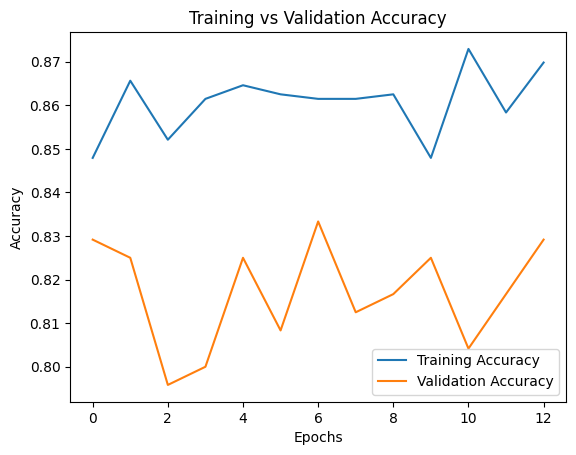

In [20]:
import matplotlib.pyplot as plt

# Make sure history is the History object returned by model.fit()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [21]:
mobile_model.save("skin_cancer_mobilenetv2.h5")

In [23]:
vgg_model.save("skin_cancer_vgg16.h5")

In [24]:
loss, accuracy = mobile_model.evaluate(train_ds, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = mobile_model.evaluate(test_ds, verbose=1)
print("Test:  accuracy = %f  ;  loss = %f" % (accuracy, loss))


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.8825 - loss: 0.2937
Train: accuracy = 0.871875  ;  loss = 0.292486
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8302 - loss: 0.3466
Test:  accuracy = 0.825000  ;  loss = 0.337231


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 906ms/step


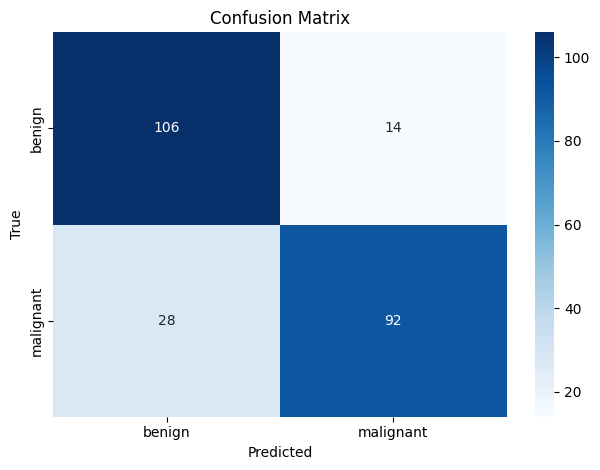

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on your tf.data test dataset
y_pred_prob = mobile_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels (label_mode='categorical' => one-hot -> class index)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, cohen_kappa_score
)

# Predict on your tf.data test dataset
y_pred_prob = mobile_model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels (label_mode='categorical' => one-hot -> class index)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
kappa = cohen_kappa_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Kappa:     {kappa:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Accuracy:  0.8250
Precision: 0.8295
Recall:    0.8250
F1-score:  0.8244
Kappa:     0.6500


In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Uses your existing `class_names` and `img_size` from the dataset setup.
# Example: class_names = train_ds.class_names ; img_size = (224, 224)

def predict_skin_cancer_image(image_path, model, class_names, img_size=(224, 224)):
    # 1) Read and validate
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Image not found or unreadable: {image_path}")

    # 2) BGR->RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 3) Resize to training size (OpenCV expects (width, height))
    h, w = img_size
    img_resized = cv2.resize(img_rgb, (w, h))

    # 4) To float32 and MobileNetV2 preprocessing
    x = img_resized.astype(np.float32)
    x = preprocess_input(x)  # If your model already includes preprocessing, remove this line.

    # 5) Add batch dimension and predict
    x = np.expand_dims(x, axis=0)
    probs = model.predict(x, verbose=0)[0]

    pred_idx = int(np.argmax(probs))
    pred_class = class_names[pred_idx]
    confidence = float(probs[pred_idx] * 100.0)

    # 6) Show image with prediction
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

    return pred_class, round(confidence, 2)




#Prediction For MobileNetV2

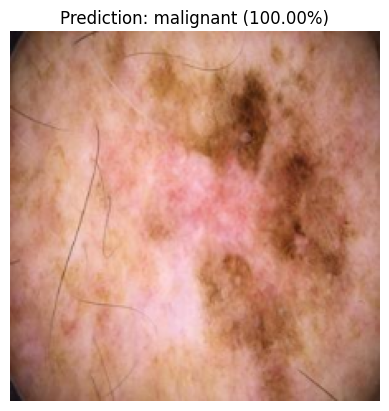

Predicted Class: malignant, Confidence: 100.00%


In [28]:
image_path = '/content/drive/MyDrive/melanoma/test/malignant/melanoma_7158.jpg'
predicted_class, confidence = predict_skin_cancer_image(
    image_path,
    mobile_model,
    class_names=class_names,
    img_size=img_size
)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

#Prediction For CNN

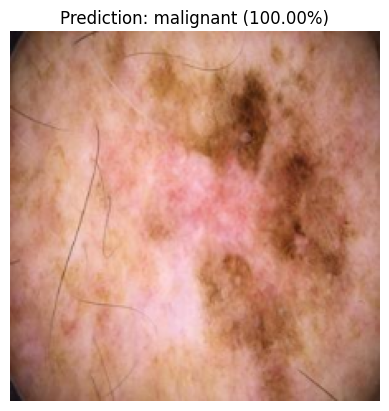

Predicted Class: malignant, Confidence: 100.00%


In [29]:
image_path = '/content/drive/MyDrive/melanoma/test/malignant/melanoma_7158.jpg'
predicted_class, confidence = predict_skin_cancer_image(
    image_path,
    cnn_model,
    class_names=class_names,
    img_size=img_size
)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

#Prediction For VGG16

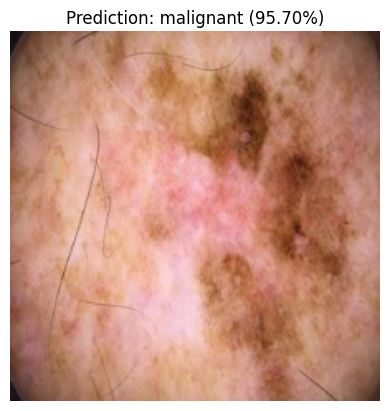

Predicted Class: malignant, Confidence: 95.70%


In [30]:
image_path = '/content/drive/MyDrive/melanoma/test/malignant/melanoma_7158.jpg'
predicted_class, confidence = predict_skin_cancer_image(
    image_path,
    vgg_model,
    class_names=class_names,
    img_size=img_size
)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")